In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, next_states, rewards, dones, rates

In [4]:
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Hidden layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        actions_logits = tf.layers.dense(inputs=nl2, units=action_size)
        return actions_logits

In [5]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Hidden layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        Qs_logits = tf.layers.dense(inputs=nl2, units=1)
        return Qs_logits

In [6]:
def model_loss(state_size, action_size, hidden_size, states, actions, next_states, rewards, dones, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    gloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    dQs = discriminator(states=states, actions=actions_labels, action_size=action_size, hidden_size=hidden_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                                   labels=rates)) # [0, 1]
    next_actions_logits = generator(states=next_states, hidden_size=hidden_size, action_size=action_size, 
                                    reuse=True)
    nextQs_logits = discriminator(states=next_states, actions=next_actions_logits, action_size=action_size, 
                                  hidden_size=hidden_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1])
    targetQs = rewards + (0.99 * nextQs * (1-dones))
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    glossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                                    labels=tf.nn.sigmoid(targetQs))) # [0, 1]
    return actions_logits, gloss, dloss, glossQ

In [7]:
def model_opt(g_loss, d_loss, g_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        g_optQ = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossQ, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt, g_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.g_loss, self.d_loss, self.g_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size, # model init parameters
            states=self.states, actions=self.actions, next_states=self.next_states, rewards=self.rewards, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.g_optQ = model_opt(g_loss=self.g_loss, 
                                                        d_loss=self.d_loss,
                                                        g_lossQ=self.g_lossQ,
                                                        g_learning_rate=g_learning_rate, 
                                                        d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            gloss, _, dloss, _ = sess.run([model.g_loss, model.g_opt, model.d_loss, model.d_opt], 
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones, 
                                                       model.rates: rates})
            glossQ, _ = sess.run([model.g_lossQ, model.g_optQ], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.next_states: next_states,
                                                                             model.rewards: rewards,
                                                                             model.dones: dones, 
                                                                             model.rates: rates})
            dloss_batch.append(dloss)
            gloss_batch.append(gloss)
            glossQ_batch.append(glossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:0.6890 dloss:0.6842 glossQ:0.6998 exploreP:0.9981
Episode:1 meanR:19.0000 R:19.0000 rate:0.0380 gloss:0.6900 dloss:0.6811 glossQ:0.7020 exploreP:0.9962
Episode:2 meanR:23.3333 R:32.0000 rate:0.0640 gloss:0.6855 dloss:0.6784 glossQ:0.7034 exploreP:0.9931
Episode:3 meanR:21.5000 R:16.0000 rate:0.0320 gloss:0.6834 dloss:0.6745 glossQ:0.7063 exploreP:0.9915
Episode:4 meanR:26.4000 R:46.0000 rate:0.0920 gloss:0.6830 dloss:0.6701 glossQ:0.7083 exploreP:0.9870
Episode:5 meanR:24.1667 R:13.0000 rate:0.0260 gloss:0.6854 dloss:0.6651 glossQ:0.7117 exploreP:0.9857
Episode:6 meanR:22.7143 R:14.0000 rate:0.0280 gloss:0.6764 dloss:0.6641 glossQ:0.7123 exploreP:0.9844
Episode:7 meanR:23.6250 R:30.0000 rate:0.0600 gloss:0.6794 dloss:0.6602 glossQ:0.7146 exploreP:0.9815
Episode:8 meanR:22.3333 R:12.0000 rate:0.0240 gloss:0.6857 dloss:0.6581 glossQ:0.7154 exploreP:0.9803
Episode:9 meanR:22.8000 R:27.0000 rate:0.0540 gloss:0.6868 dloss:0.6558 glossQ:0.7

Episode:80 meanR:26.9259 R:37.0000 rate:0.0740 gloss:0.8106 dloss:0.4053 glossQ:0.5711 exploreP:0.8060
Episode:81 meanR:26.7683 R:14.0000 rate:0.0280 gloss:0.7784 dloss:0.3858 glossQ:0.5861 exploreP:0.8049
Episode:82 meanR:26.9398 R:41.0000 rate:0.0820 gloss:0.8816 dloss:0.4087 glossQ:0.5527 exploreP:0.8016
Episode:83 meanR:27.0119 R:33.0000 rate:0.0660 gloss:0.8346 dloss:0.4049 glossQ:0.5187 exploreP:0.7990
Episode:84 meanR:26.8471 R:13.0000 rate:0.0260 gloss:0.7847 dloss:0.3991 glossQ:0.5262 exploreP:0.7980
Episode:85 meanR:26.7558 R:19.0000 rate:0.0380 gloss:0.7633 dloss:0.3864 glossQ:0.5180 exploreP:0.7965
Episode:86 meanR:26.8506 R:35.0000 rate:0.0700 gloss:0.8275 dloss:0.3989 glossQ:0.5006 exploreP:0.7938
Episode:87 meanR:27.2386 R:61.0000 rate:0.1220 gloss:0.7506 dloss:0.3916 glossQ:0.4610 exploreP:0.7890
Episode:88 meanR:27.1461 R:19.0000 rate:0.0380 gloss:0.7243 dloss:0.3839 glossQ:0.4434 exploreP:0.7875
Episode:89 meanR:26.9889 R:13.0000 rate:0.0260 gloss:0.7574 dloss:0.3871 

Episode:159 meanR:44.5000 R:79.0000 rate:0.1580 gloss:0.6690 dloss:0.4029 glossQ:0.1742 exploreP:0.5518
Episode:160 meanR:44.4400 R:19.0000 rate:0.0380 gloss:0.6696 dloss:0.4082 glossQ:0.1937 exploreP:0.5507
Episode:161 meanR:44.5700 R:27.0000 rate:0.0540 gloss:0.6699 dloss:0.4073 glossQ:0.1666 exploreP:0.5493
Episode:162 meanR:44.9300 R:53.0000 rate:0.1060 gloss:0.6719 dloss:0.3884 glossQ:0.1708 exploreP:0.5464
Episode:163 meanR:45.8000 R:101.0000 rate:0.2020 gloss:0.6702 dloss:0.3894 glossQ:0.1687 exploreP:0.5410
Episode:164 meanR:46.0300 R:68.0000 rate:0.1360 gloss:0.6662 dloss:0.4001 glossQ:0.1857 exploreP:0.5374
Episode:165 meanR:46.2100 R:40.0000 rate:0.0800 gloss:0.6694 dloss:0.4006 glossQ:0.1682 exploreP:0.5353
Episode:166 meanR:46.8400 R:76.0000 rate:0.1520 gloss:0.6703 dloss:0.3929 glossQ:0.1682 exploreP:0.5313
Episode:167 meanR:46.0700 R:24.0000 rate:0.0480 gloss:0.6722 dloss:0.3994 glossQ:0.1670 exploreP:0.5301
Episode:168 meanR:46.2700 R:67.0000 rate:0.1340 gloss:0.6704 dl

Episode:237 meanR:176.4200 R:230.0000 rate:0.4600 gloss:0.6579 dloss:0.5658 glossQ:0.2922 exploreP:0.1173
Episode:238 meanR:178.3300 R:302.0000 rate:0.6040 gloss:0.6574 dloss:0.5521 glossQ:0.2957 exploreP:0.1141
Episode:239 meanR:182.9500 R:500.0000 rate:1.0000 gloss:0.6557 dloss:0.5481 glossQ:0.2924 exploreP:0.1090
Episode:240 meanR:184.1500 R:148.0000 rate:0.2960 gloss:0.6672 dloss:0.5627 glossQ:0.2957 exploreP:0.1075
Episode:241 meanR:185.7100 R:211.0000 rate:0.4220 gloss:0.6557 dloss:0.5734 glossQ:0.2970 exploreP:0.1055
Episode:242 meanR:186.7800 R:206.0000 rate:0.4120 gloss:0.6561 dloss:0.5245 glossQ:0.2928 exploreP:0.1036
Episode:243 meanR:188.5100 R:266.0000 rate:0.5320 gloss:0.6602 dloss:0.5326 glossQ:0.2899 exploreP:0.1011
Episode:244 meanR:189.9200 R:266.0000 rate:0.5320 gloss:0.6620 dloss:0.5243 glossQ:0.2889 exploreP:0.0987
Episode:245 meanR:192.4800 R:273.0000 rate:0.5460 gloss:0.6597 dloss:0.5691 glossQ:0.2921 exploreP:0.0963
Episode:246 meanR:194.3100 R:273.0000 rate:0.5

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

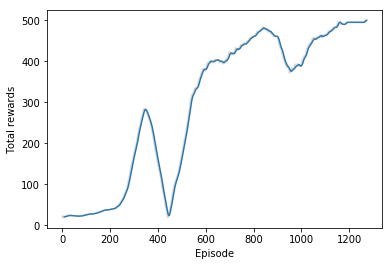

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

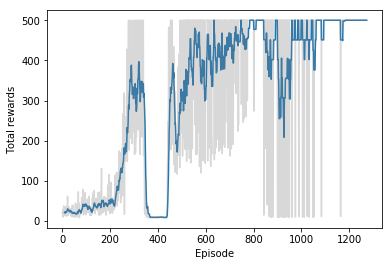

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [18]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [20]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 200.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 11.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.